Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
# !pip install --upgrade tensorflow-gpu
# !pip install pydot

In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from glob import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [1]:
!nvidia-smi

Tue Sep 13 18:15:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

#### Connecting with GDrive to load data into notebook

In [3]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# !unzip /content/gdrive/MyDrive/CNN_assignment.zip

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [6]:
## Training Dataset

train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height, img_width),
  seed = 123,
  subset = "training",
  validation_split = 0.2
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


2022-09-13 18:15:28.018068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 18:15:28.019449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 18:15:28.031356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 18:15:28.032118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 18:15:28.032794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [7]:
## Validation Dataset 

valid = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height, img_width),
  seed = 123,
  subset = "validation",
  validation_split = 0.2
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List of all the classes of skin cancer and store them in a list. 
classnames = train.class_names
print(classnames,  len(classnames))
print(train)
print(valid)
num_classes = len(classnames)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 9
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

In [9]:
class_names = train.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Found 6739 files belonging to 9 classes.


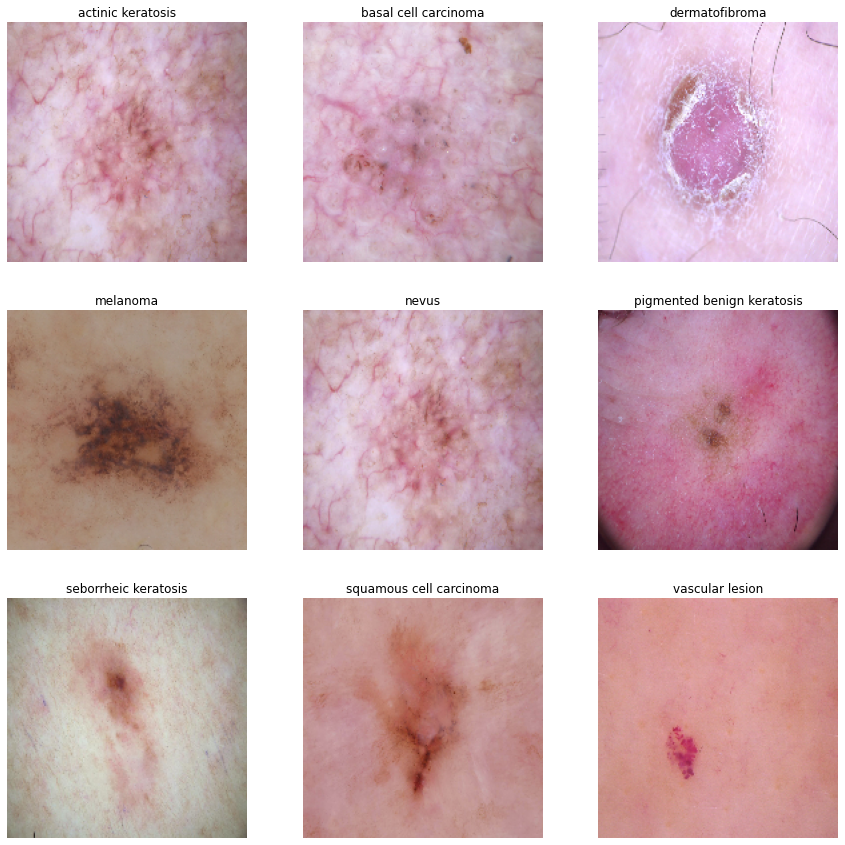

In [10]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valid.cache().prefetch(buffer_size=AUTOTUNE)

### CNN Model
#### Creating CNN model, which can accurately detect 9 classes present in the dataset.

* ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1)
* The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.010784314 0.8862746


In [14]:
num_classes = 9

model = tf.keras.Sequential([
    
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3) ),

    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='gelu'),

    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128,  activation='gelu'),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')

])

In [15]:
# View the summary of all layers
input_shape = (32, 180, 180, 3)
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        3

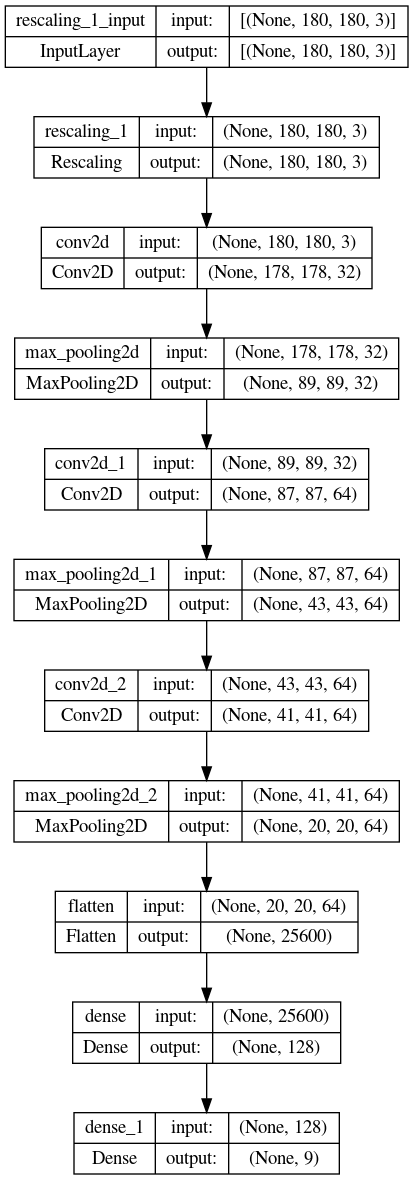

In [16]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Optimiser and loss function for model training 

In [17]:
## optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train,
  validation_data=valid,
  epochs=epochs
)

Epoch 1/20


2022-09-13 18:18:55.604090: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


169/169 [==============================] - 19s 90ms/step - loss: 1.7465 - accuracy: 0.3333 - val_loss: 1.4358 - val_accuracy: 0.4692
Epoch 2/20
169/169 [==============================] - 14s 81ms/step - loss: 1.3999 - accuracy: 0.4759 - val_loss: 1.2766 - val_accuracy: 0.5226
Epoch 3/20
169/169 [==============================] - 14s 81ms/step - loss: 1.1320 - accuracy: 0.5833 - val_loss: 1.0912 - val_accuracy: 0.6192
Epoch 4/20
169/169 [==============================] - 14s 81ms/step - loss: 0.8509 - accuracy: 0.7007 - val_loss: 0.8475 - val_accuracy: 0.6971
Epoch 5/20
169/169 [==============================] - 15s 86ms/step - loss: 0.5472 - accuracy: 0.8160 - val_loss: 0.7457 - val_accuracy: 0.7498
Epoch 6/20
169/169 [==============================] - 14s 81ms/step - loss: 0.3748 - accuracy: 0.8700 - val_loss: 0.7578 - val_accuracy: 0.7736
Epoch 7/20
169/169 [==============================] - 14s 81ms/step - loss: 0.2708 - accuracy: 0.9071 - val_loss: 0.8759 - val_accuracy: 0.7595
Epo

### Visualizing training results

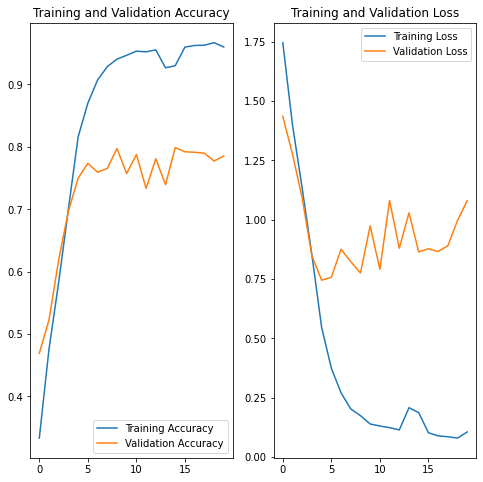

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### In Plot we can easly see that out model get overfitted after 5 epoch

* Model seems overfitted to the dataset.
* Have to Add Dropout layer into model
* Have to Do Data Augmentation.

### Model with Dropout

In [20]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3) ),
    
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='gelu'),
    
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')

])

### Compiling the model

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
# View the summary of all layers
input_shape = (32, 180, 180, 3)
model.build(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 64)       

### Training the model

In [24]:
epochs = 20
history = model.fit(
  train,
  validation_data=valid,
  epochs=epochs
)

Epoch 1/20


/opt/conda/envs/tarun/lib/python3.7/site-packages/keras/backend.py:5532: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


169/169 [==============================] - 16s 88ms/step - loss: 1.8387 - accuracy: 0.3049 - val_loss: 1.6956 - val_accuracy: 0.3526
Epoch 2/20
169/169 [==============================] - 14s 81ms/step - loss: 1.4852 - accuracy: 0.4410 - val_loss: 1.3015 - val_accuracy: 0.5041
Epoch 3/20
169/169 [==============================] - 14s 81ms/step - loss: 1.3046 - accuracy: 0.5159 - val_loss: 1.1682 - val_accuracy: 0.5895
Epoch 4/20
169/169 [==============================] - 14s 81ms/step - loss: 1.0634 - accuracy: 0.6161 - val_loss: 0.9266 - val_accuracy: 0.6570
Epoch 5/20
169/169 [==============================] - 15s 88ms/step - loss: 0.8346 - accuracy: 0.7088 - val_loss: 0.8563 - val_accuracy: 0.6978
Epoch 6/20
169/169 [==============================] - 14s 81ms/step - loss: 0.6569 - accuracy: 0.7717 - val_loss: 0.7407 - val_accuracy: 0.7647
Epoch 7/20
169/169 [==============================] - 14s 81ms/step - loss: 0.4875 - accuracy: 0.8292 - val_loss: 0.6760 - val_accuracy: 0.7699
Epo

### Visualizing the results

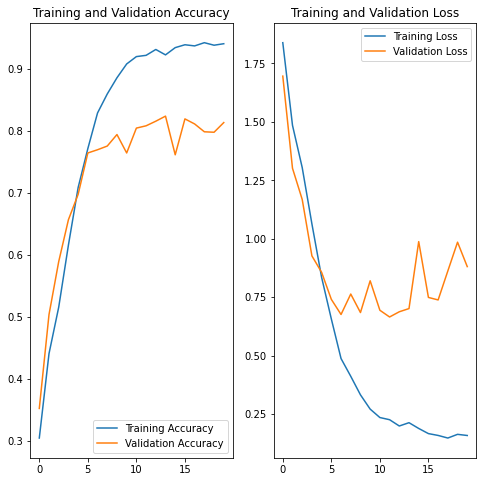

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Still Our model getting overfitted, but this time it overfitted after 10 epochs

#### Finding the distribution of classes in the training dataset.


In [26]:
val_count = []

for i in class_names:
  pth = "{}/{}/*jpg".format(data_dir_train, i)
  val_count.append(len(glob(pth)))

df = pd.DataFrame(list(zip(class_names,val_count)),columns =['Class', 'No. of Image'])
df.head()

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

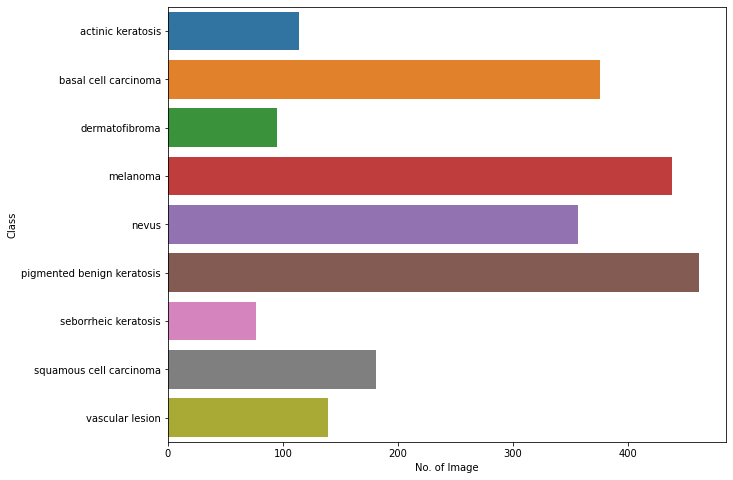

In [27]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [29]:
df.head(10)

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139



#### - ```seborrheic keratosis``` class has the least number of samples?
#### - ```pigmented benign keratosis``` and ```melanoma``` classes dominate the data in terms proportionate 462 and 438 number of samples


#### Doing class imbalance
#### Using python package known as `Augmentor` [link](https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"


import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F314149F310>: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 88.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F32252F79D0>: 100%|████████████████████| 500/500 [00:05<00:00, 85.55 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3225253850>: 100%|███████████████████| 500/500 [00:04<00:00, 104.85 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F329CEDBC90>: 100%|█████████████████████████████████████| 500/500 [00:20<00:00, 24.02 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F32251D1490>: 100%|██████████████████████████████████████| 500/500 [00:19<00:00, 25.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F329CDF3850>: 100%|█████████████████████████████████████| 500/500 [00:04<00:00, 103.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F31502A3590>: 100%|█████████████████████████████████████| 500/500 [00:13<00:00, 37.72 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3225262F10>: 100%|█████████████████████████████████████| 500/500 [00:04<00:00, 101.87 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F329DFF2D50>: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 97.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

11209


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,melanoma,438
2,basal cell carcinoma,376
3,pigmented benign keratosis,462
4,squamous cell carcinoma,181
5,nevus,357
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


In [35]:
val_count = []

for i in class_names:
  pth = "{}/{}/*jpg".format(data_dir_train, i)
  pth1 = "{}/{}/output/*jpg".format(data_dir_train, i)
  out = len(glob(pth)) + len(glob(pth)) 
  val_count.append(out)

df = pd.DataFrame(list(zip(class_names,val_count)),columns =['Class', 'No. of Image'])
df.head()

,Class,No. of Image
0,actinic keratosis,228
1,basal cell carcinoma,752
2,dermatofibroma,190
3,melanoma,876
4,nevus,714


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

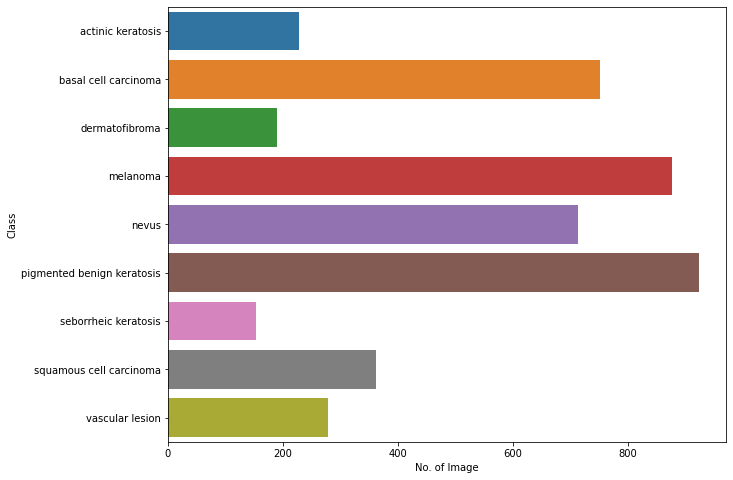

In [36]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13448 files belonging to 9 classes.
Using 10759 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13448 files belonging to 9 classes.
Using 2689 files for validation.


In [41]:
out1, out2 = next(iter(train_ds))
print(out1.shape, out2.shape)

(32, 180, 180, 3) (32, 9)


#### CNN Model

In [42]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3) ),
    
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='gelu'),
    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='gelu'),
    
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')

])

#### **Todo:** Compiling model

In [43]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [46]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
# earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### Model Training

In [47]:
# Train the model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint])

Epoch 1/30
337/337 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.3745
Epoch 1: val_accuracy improved from -inf to 0.47824, saving model to model.h5
337/337 [==============================] - 29s 82ms/step - loss: 1.6602 - accuracy: 0.3745 - val_loss: 1.4317 - val_accuracy: 0.4782
Epoch 2/30
336/337 [============================>.] - ETA: 0s - loss: 1.2295 - accuracy: 0.5477
Epoch 2: val_accuracy improved from 0.47824 to 0.66642, saving model to model.h5
337/337 [==============================] - 27s 78ms/step - loss: 1.2292 - accuracy: 0.5478 - val_loss: 0.9501 - val_accuracy: 0.6664
Epoch 3/30
336/337 [============================>.] - ETA: 0s - loss: 0.8351 - accuracy: 0.7015
Epoch 3: val_accuracy improved from 0.66642 to 0.78356, saving model to model.h5
337/337 [==============================] - 28s 83ms/step - loss: 0.8350 - accuracy: 0.7017 - val_loss: 0.6356 - val_accuracy: 0.7836
Epoch 4/30
336/337 [============================>.] - ETA: 0s - loss: 0.5

#### Visualize the model results

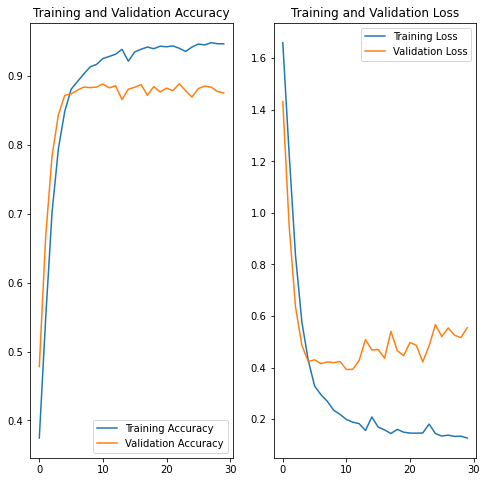

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Now our Model is Good fit.

1/1 [==============================] - 0s 134ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


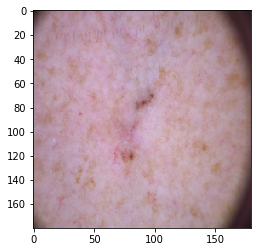

In [49]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

#### Conclusion

After handeling inbalance our CNN model is performing better on dataset.